In [1]:
import numpy as np
import itertools

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-poster')

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:

from MomentMatching.newMomentMatch import MomentMatching, UnscentedTransform, TaylorTransform, MonteCarloTransform
from MomentMatching.TimeSeriesModel import TimeSeriesModel, UniformNonlinearGrowthModel
from MomentMatching.StateModels import GaussianState
from MomentMatching.ExpectationPropagation import EPNodes, TopEP

In [36]:
np.random.seed(seed=125)

In [37]:
N = 50
system = UniformNonlinearGrowthModel()
data = system.simulate(N)
x_true, x_noisy, y_true, y_noisy = zip(*data)

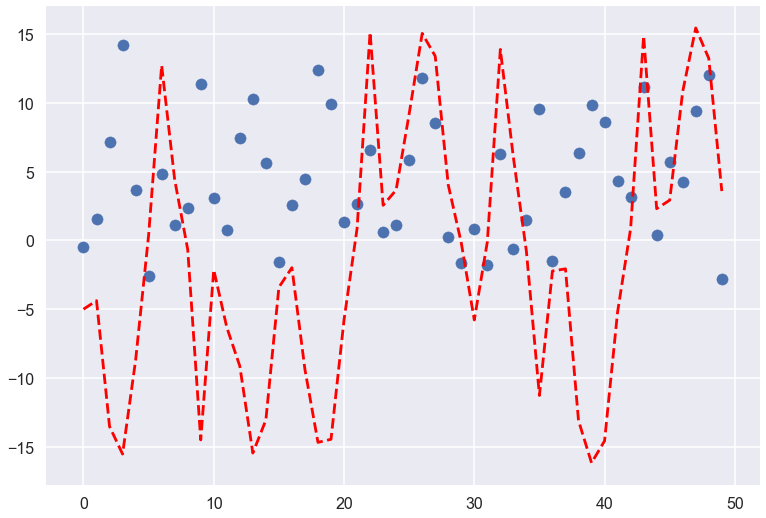

In [39]:
plt.plot(x_true, 'r--')
plt.scatter(list(range(N)), y_noisy)
# plt.plot(y_noisy)
# plt.plot(y_true, 'g--')
plt.show()

In [47]:
# transform = TaylorTransform(dimension_of_state=1)
transform = UnscentedTransform(n=1)
# transform = MonteCarloTransform(dimension_of_state=1)
Nodes = EPNodes(dimension_of_state=1, N=N)
EP = TopEP(system_model=system, moment_matching=transform)


In [41]:
prior = Nodes[0].copy()
prior.marginal = system.init_state

In [42]:
system.init_state

GaussianState 
 mean=
 [ 0.1], 
 cov=
[[ 1.]])

In [43]:
# EP.forward_update(Nodes[0], prior, 0.0)

In [12]:
def EP_update(self, Nodes, observations, fargs_list):
    prior = Nodes[0].copy()
    prior.marginal = self.system_model.init_state
        # GaussianState(mean_vec=np.array([0.1]),
        #                            cov_matrix=0.1 * np.eye(1, dtype=float))
    node_iter, next_node_iter = itertools.tee(Nodes)
    next(next_node_iter, None)
    for node, next_node, obs, fargs in itertools.zip_longest(node_iter, next_node_iter, observations, fargs_list):
        pred_state = self.forward_update(node=node, prev_node=prior, fargs=fargs)
        corrected_state = self.measurement_update(pred_state, obs, fargs)
        
        if next_node is not None:
            smoothed_state = self.backward_update(corrected_state, next_node=next_node, fargs=fargs )
        else:
            smoothed_state = corrected_state
            
        yield smoothed_state
        prior = smoothed_state

In [13]:
def kalman_filter(self, Nodes, observations, fargs_list):
    prior = Nodes[0].copy()
    prior.marginal = self.system_model.init_dist
        # GaussianState(mean_vec=np.array([0.1]),
        #                            cov_matrix=0.1 * np.eye(1, dtype=float))

    for node, obs, fargs in zip(Nodes, observations, fargs_list):
        pred_state = self.forward_update(node=node, prev_node=prior, fargs=fargs)
        corrected_state = self.measurement_update(pred_state, obs, fargs)
        yield corrected_state
        prior = corrected_state

        


In [14]:
# system.Q.cov

In [48]:
ans = EP.kalman_filter(Nodes, y_noisy, list(range(0, N)))

In [49]:
# ans2 = EP_update(EP, Nodes, y_noisy, range(0, N))
# ep_data = list(ans2)

In [50]:
x_filtered = list(ans)
x_filt_mean = [x.marginal.mean for x in x_filtered]

LinAlgError: Matrix is not positive definite

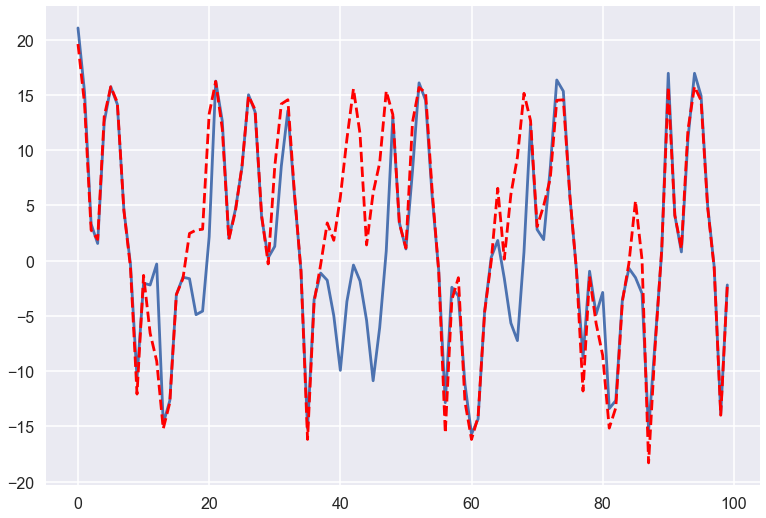

In [31]:
plt.plot(x_filt_mean)
plt.plot(x_true, 'r--', label='x_true')

In [19]:
def plot_gaussian(data):
    x_mean = np.array([x.marginal.mean for x in data])
    x_sigma = np.array([np.sqrt(x.marginal.cov[0, :]) for x in data])
    
    upr = x_mean + 2 * x_sigma
    lwr = x_mean - 2 * x_sigma
#     print(x_mean.shape)
#     print(upr.shape)
#     plt.plot(x_mean)
#     plt.plot(lwr)
#     plt.plot(upr)
#     ax.plt.figure()
    time = np.arange(len(data))
#     time = time[:, np.newaxis]
#     print(time.shape)
    plt.fill_between(time, lwr[:,0], upr[:,0], alpha=0.5)
    
#     print (x1)
#     print(x2)
#     print(x1 + 2 * x2)
#     print(x1 - 2 * x2)

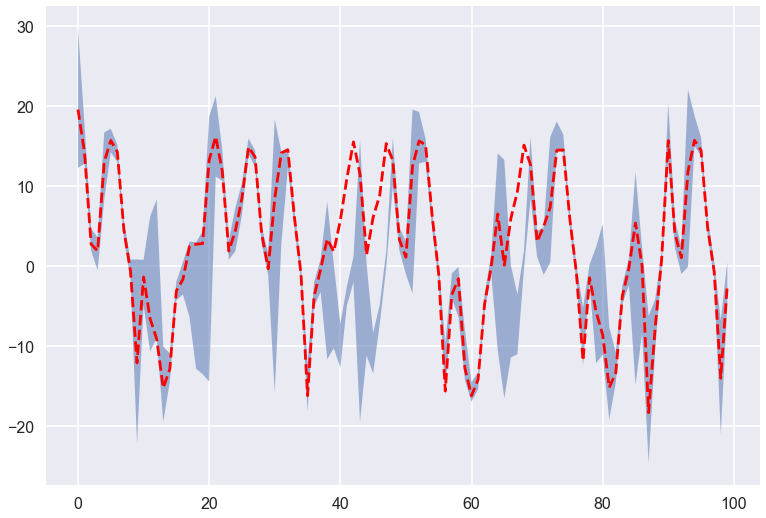

In [32]:
plot_gaussian(x_filtered)
plt.plot(x_true, 'r--', label='x_true')

In [21]:
def kalman_smoother(self, Nodes, fargs_list):
    
    reversedNodes = reversed(Nodes)
    reveresedFargs = reversed(fargs_list)
    
    # Last filtered value is same as first smoothed
    next(reveresedFargs)
    next_node = next(reversedNodes)
    yield next_node
    
    for node, fargs in zip(reversedNodes, reveresedFargs):

        smoothed_node = self.backward_update(node=node, next_node=next_node, fargs=fargs)
#         print(f'node {node.t},  next_node {next_node.t}' )
        yield smoothed_node
        next_node = smoothed_node.copy()
        

In [22]:
sms = kalman_smoother(EP, x_filtered, list(range(0, N)))
x_smoothed = (list(sms))

in node 98 and t is 98 
in node 97 and t is 97 
in node 96 and t is 96 
in node 95 and t is 95 
in node 94 and t is 94 
in node 93 and t is 93 
in node 92 and t is 92 
in node 91 and t is 91 
in node 90 and t is 90 
in node 89 and t is 89 
in node 88 and t is 88 
in node 87 and t is 87 
in node 86 and t is 86 
in node 85 and t is 85 
in node 84 and t is 84 
in node 83 and t is 83 
in node 82 and t is 82 
in node 81 and t is 81 
in node 80 and t is 80 
in node 79 and t is 79 
in node 78 and t is 78 
in node 77 and t is 77 
in node 76 and t is 76 
in node 75 and t is 75 
in node 74 and t is 74 
in node 73 and t is 73 
in node 72 and t is 72 
in node 71 and t is 71 
in node 70 and t is 70 
in node 69 and t is 69 
in node 68 and t is 68 
in node 67 and t is 67 
in node 66 and t is 66 
in node 65 and t is 65 
in node 64 and t is 64 
in node 63 and t is 63 
in node 62 and t is 62 
in node 61 and t is 61 
in node 60 and t is 60 
in node 59 and t is 59 
in node 58 and t is 58 
in node 57 and t

/Users/Pontragyin/Documents/GitHub/pyStateEstimator/MomentMatching/StateModels.py:133: UserWarning: Negative Precision!!!
  warnings.warn('Negative Precision!!!')



in node 5 and t is 5 
in node 4 and t is 4 
in node 3 and t is 3 
in node 2 and t is 2 
in node 1 and t is 1 
in node 0 and t is 0 


In [23]:

x_smoothed_mean = [x.marginal.mean for x in reversed(x_smoothed)]

In [24]:
[x.marginal.cov for x in reversed(x_smoothed)]

[array([[ 5.5912]]),
 array([[ 0.771]]),
 array([[ 1.5778]]),
 array([[ 0.8619]]),
 array([[ 4.8802]]),
 array([[ 0.4022]]),
 array([[ 0.4557]]),
 array([[ 0.2413]]),
 array([[ 0.0926]]),
 array([[ 11.2166]]),
 array([[ 2.2385]]),
 array([[ 10.3053]]),
 array([[ 7.181]]),
 array([[ 2.016]]),
 array([[ 0.1486]]),
 array([[ 0.6953]]),
 array([[ 0.7268]]),
 array([[ 3.2129]]),
 array([[ 9.2168]]),
 array([[ 20.3164]]),
 array([[ 35.4285]]),
 array([[ 7.1844]]),
 array([[ 0.6858]]),
 array([[ 0.0459]]),
 array([[ 4.6391]]),
 array([[ 0.9027]]),
 array([[ 0.2779]]),
 array([[ 0.1931]]),
 array([[ 2.6348]]),
 array([[ 0.4472]]),
 array([[ 42.3025]]),
 array([[ 5.9327]]),
 array([[ 3.5435]]),
 array([[ 0.2965]]),
 array([[ 0.1302]]),
 array([[ 0.9471]]),
 array([[ 0.8108]]),
 array([[ 0.6556]]),
 array([[ 14.1893]]),
 array([[ 2.5185]]),
 array([[ 0.1978]]),
 array([[ 0.7563]]),
 array([[ 0.4694]]),
 array([[ 38.1154]]),
 array([[ 3.2154]]),
 array([[ 19.0323]]),
 array([[ 0.3717]]),
 array([

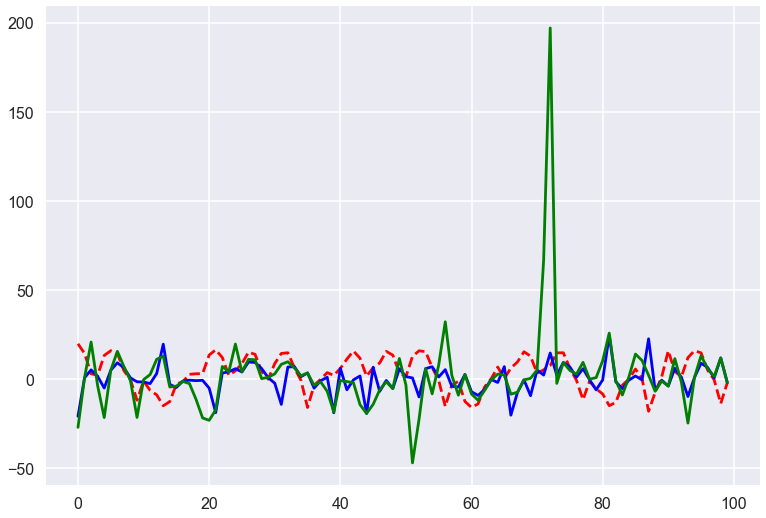

In [25]:
plt.plot(x_true, 'r--', label='x_true')
plt.plot(x_filt_mean, 'b', label='x_filtered')
plt.plot(x_smoothed_mean, 'g', label='x_smoothed')


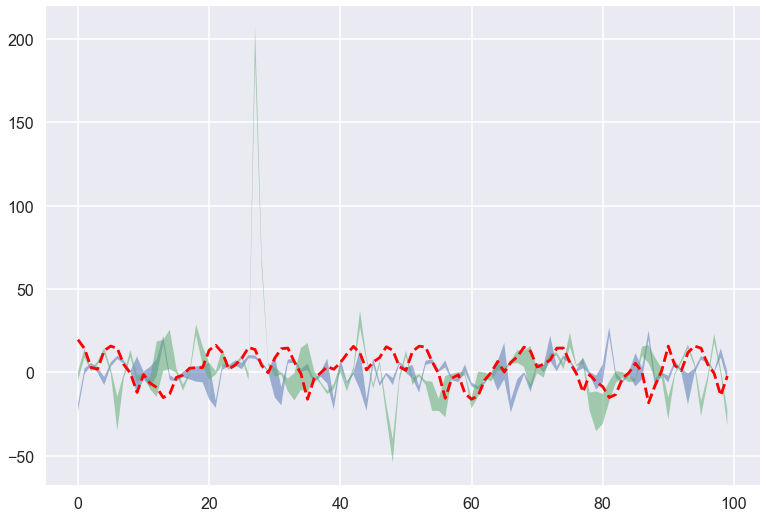

In [26]:
plot_gaussian(x_filtered)
plot_gaussian(x_smoothed)
plt.plot(x_true, 'r--', label='x_true')

In [27]:
data_list = list(reversed(x_smoothed))
for data in data_list:
    print(data.marginal.cov)

[[ 5.5912]]
[[ 0.771]]
[[ 1.5778]]
[[ 0.8619]]
[[ 4.8802]]
[[ 0.4022]]
[[ 0.4557]]
[[ 0.2413]]
[[ 0.0926]]
[[ 11.2166]]
[[ 2.2385]]
[[ 10.3053]]
[[ 7.181]]
[[ 2.016]]
[[ 0.1486]]
[[ 0.6953]]
[[ 0.7268]]
[[ 3.2129]]
[[ 9.2168]]
[[ 20.3164]]
[[ 35.4285]]
[[ 7.1844]]
[[ 0.6858]]
[[ 0.0459]]
[[ 4.6391]]
[[ 0.9027]]
[[ 0.2779]]
[[ 0.1931]]
[[ 2.6348]]
[[ 0.4472]]
[[ 42.3025]]
[[ 5.9327]]
[[ 3.5435]]
[[ 0.2965]]
[[ 0.1302]]
[[ 0.9471]]
[[ 0.8108]]
[[ 0.6556]]
[[ 14.1893]]
[[ 2.5185]]
[[ 0.1978]]
[[ 0.7563]]
[[ 0.4694]]
[[ 38.1154]]
[[ 3.2154]]
[[ 19.0323]]
[[ 0.3717]]
[[ 0.1221]]
[[ 1.0662]]
[[ 0.6455]]
[[ 0.6015]]
[[ 12.665]]
[[ 3.2749]]
[[ 0.3933]]
[[ 0.3964]]
[[ 0.2291]]
[[ 6.4839]]
[[ 0.4455]]
[[ 1.1107]]
[[ 1.3133]]
[[ 0.645]]
[[ 0.255]]
[[ 0.0886]]
[[ 0.8291]]
[[ 56.5842]]
[[ 39.1704]]
[[ 16.9532]]
[[ 3.5075]]
[[ 0.1253]]
[[ 1.8209]]
[[ 0.0969]]
[[ 2.4174]]
[[ 24.0533]]
[[ 1.1643]]
[[ 0.2692]]
[[ 0.3051]]
[[ 0.1698]]
[[ 5.6298]]
[[ 0.2796]]
[[ 6.6614]]
[[ 7.7303]]
[[ 2.6042]]
[[ 0.1539

In [28]:
ans = EP_update(EP, list(reversed(x_smoothed)), y_noisy, range(0, N))
x_filtered2 = list(ans)

in node 0 and t is 0 
in node 1 and t is 1 
in node 2 and t is 2 
in node 3 and t is 3 
in node 4 and t is 4 
in node 5 and t is 5 


/Users/Pontragyin/Documents/GitHub/pyStateEstimator/MomentMatching/StateModels.py:133: UserWarning: Negative Precision!!!
  warnings.warn('Negative Precision!!!')


LinAlgError: Matrix is not positive definite

In [ ]:
x_filt_mean2 = [x.marginal.mean for x in x_filtered2]

In [ ]:
plt.plot(x_true, 'r--', label='x_true')
plt.plot(x_filt_mean, 'b', label='x_filtered')
plt.plot(x_smoothed_mean, 'g', label='x_smoothed')
plt.plot(x_filt_mean2, 'b--', label='x_smthd_filt')

In [ ]:
np.inf